Test to see if training the networks on a more ellpiticity distribution uniform than it really is would decrease the bias observed: 

---> YES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from tools_for_VAE.results_processing import VAE_processing

In [4]:
from importlib import reload
import generator_vae
reload(plot)
reload(generator_vae)

from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [5]:
from generator import BatchGenerator

ModuleNotFoundError: No module named 'generator'

# Loading the trained VAE

In [6]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True)

Instructions for updating:
Colocations handled automatically by placer.


In [42]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_uni/weights/',6, folder= True) #v12/bis5

In [8]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v9/bis2/mse/',10, folder = True)

# Generators

In [6]:
list_of_samples_new=['/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/galaxies_test_v5.npy']

In [7]:
scale_radius = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/scale_radius_test_v5.npy', mmap_mode = 'c')

In [8]:
SNR_peak_old = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/SNR_peak_test_v5.npy')

In [9]:
SNR = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/SNR_test_v5.npy')

In [11]:
bands_r = [6]

In [12]:
batch_gen_new = generator.BatchGenerator(bands_r, list_of_samples_new, total_sample_size=10000, 
                                         batch_size= 100, size_of_lists = 10000, 
                                         scale_radius = scale_radius,SNR = SNR, 
                                         trainval_or_test = 'test', 
                                         noisy = True)

TypeError: __init__() missing 1 required positional argument: 'do_norm'

In [10]:
bands_lsst = [4,5,6,7,8,9]

In [11]:
batch_gen_lsst = generator.BatchGenerator(bands_lsst, list_of_samples_new, total_sample_size=None,
                                    batch_size=100, size_of_lists=None,
                                    scale_radius=None, SNR=None,
                                    trainval_or_test='validation',
                                    noisy=True, do_norm=True, list_of_weights_e= None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [ ]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [13]:
batch_gen_lsst_euclid = generator.BatchGenerator(bands_lsst_euclid, list_of_samples_new,total_sample_size=10000, 
                                                 batch_size= 100, size_of_lists = 10000, 
                                                 scale_radius = scale_radius, SNR = SNR, 
                                                 trainval_or_test = 'test', 
                                                 noisy = True)

NameError: name 'bands_lsst_euclid' is not defined

In [12]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot for LSST all filters

In [13]:
list_of_weights_e_val = ['/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/e_beta_val.npy']

In [73]:
weights = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/e_beta_4.npy')

In [74]:
weights

array([[0.00081189],
       [0.00080775],
       [0.00138984],
       ...,
       [0.00074907],
       [0.00089269],
       [0.00076656]])

In [75]:
np.sum(weights)

94.39359835186949

In [47]:
np.where(weights == 0)[0]

array([], dtype=int64)

In [14]:
list_of_samples_val = ['/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/images_cropped_val.npy']

In [15]:
batch_gen_lsst_test = generator.BatchGenerator(bands_lsst, list_of_samples_val, total_sample_size=None,
                                    batch_size=100, size_of_lists=None,
                                    scale_radius=None, SNR=None,
                                    trainval_or_test='training',
                                    noisy=True, do_norm=True, list_of_weights_e = list_of_weights_e_val )

[BatchGenerator] total_sample_size =  40000
[BatchGenerator] len(list_of_samples) =  1


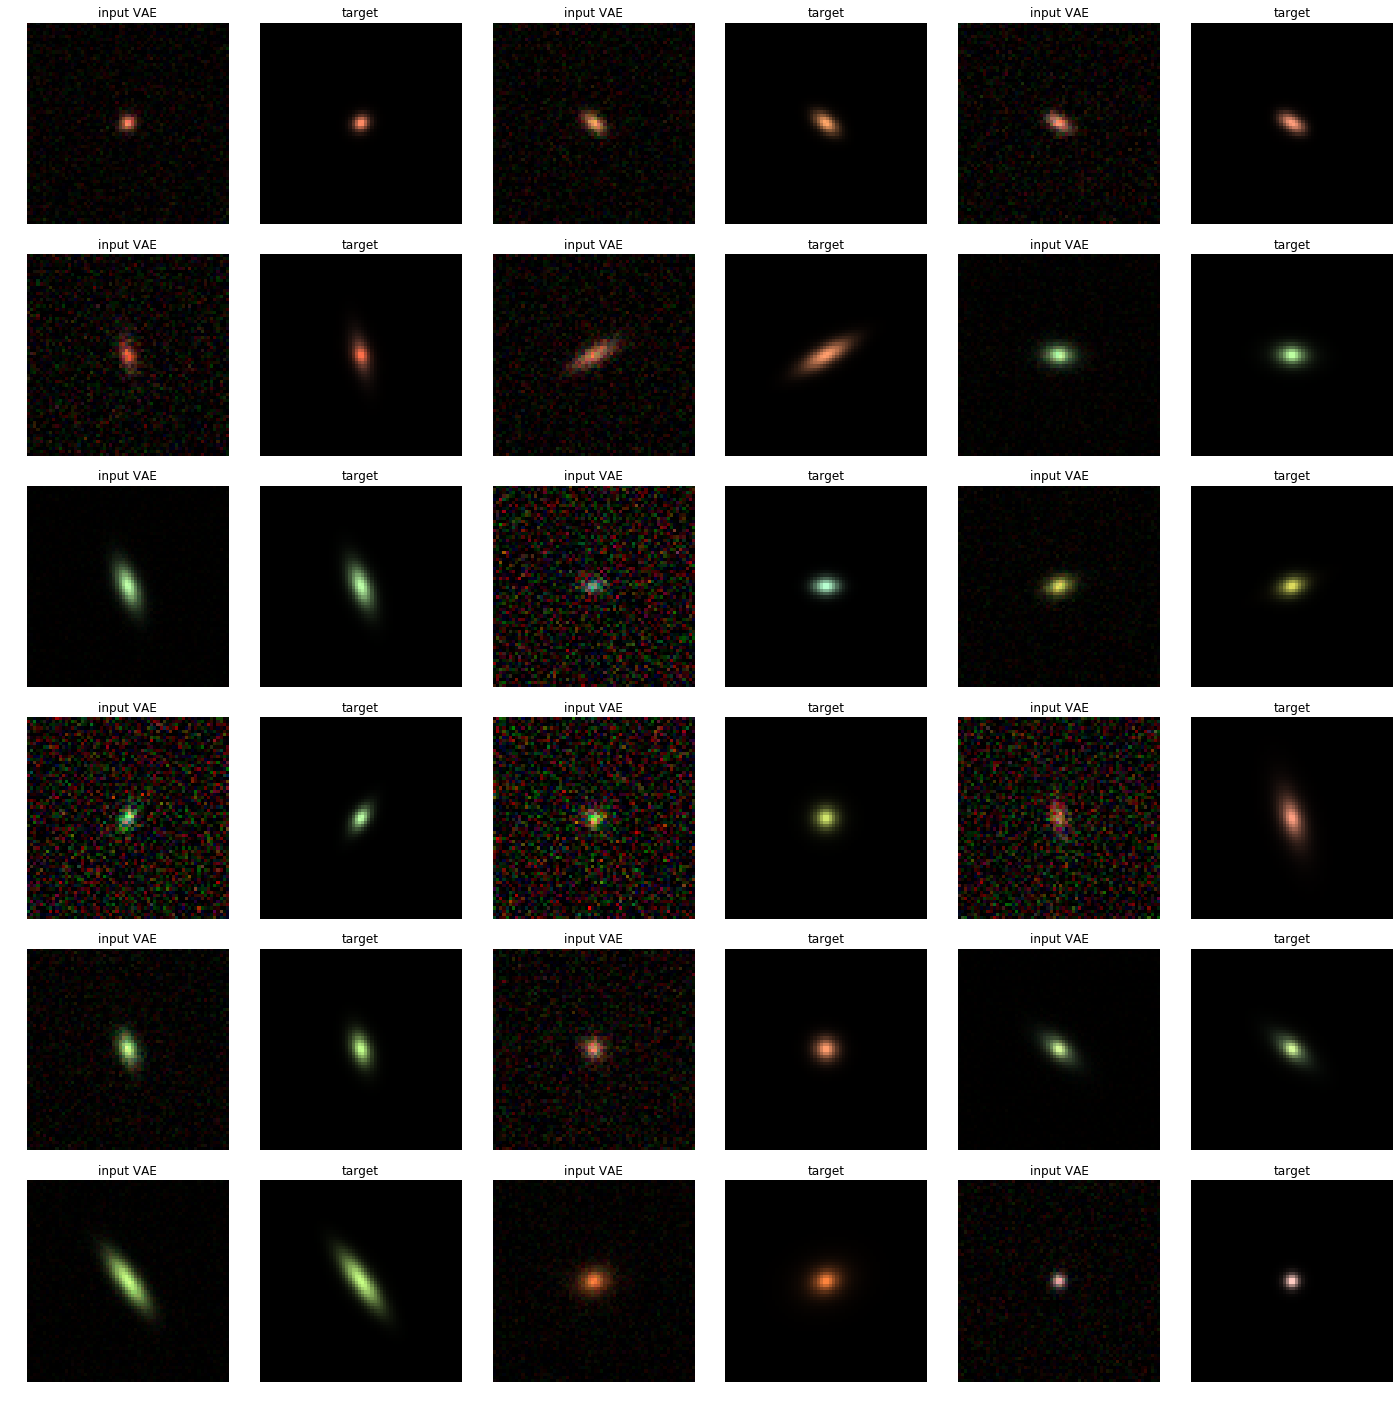

In [21]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_test.__getitem__(2)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+1])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target')

In [71]:
input_vae = batch_gen_lsst_test.__getitem__(2)

#input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
#input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)

input_noisy = input_vae[0]
input_noiseless = input_vae[1]

In [72]:
np.max(input_noisy)

0.9994569608058653

In [73]:
np.max(input_noiseless)

0.009668187721435047

In [28]:
galaxies = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/images_cropped_val.npy')#images_cropped_val.npy')

In [29]:
galaxies.shape

(40000, 2, 10, 64, 64)

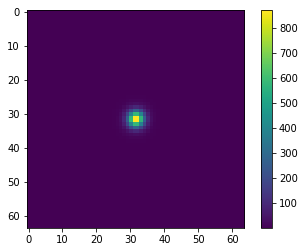

In [30]:
plt.imshow(galaxies[0][0,6])
plt.colorbar()

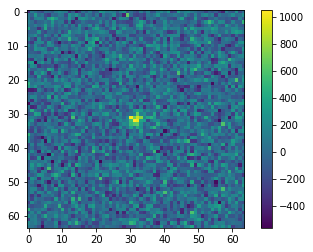

In [31]:
plt.imshow(galaxies[0][1,6])
plt.colorbar()

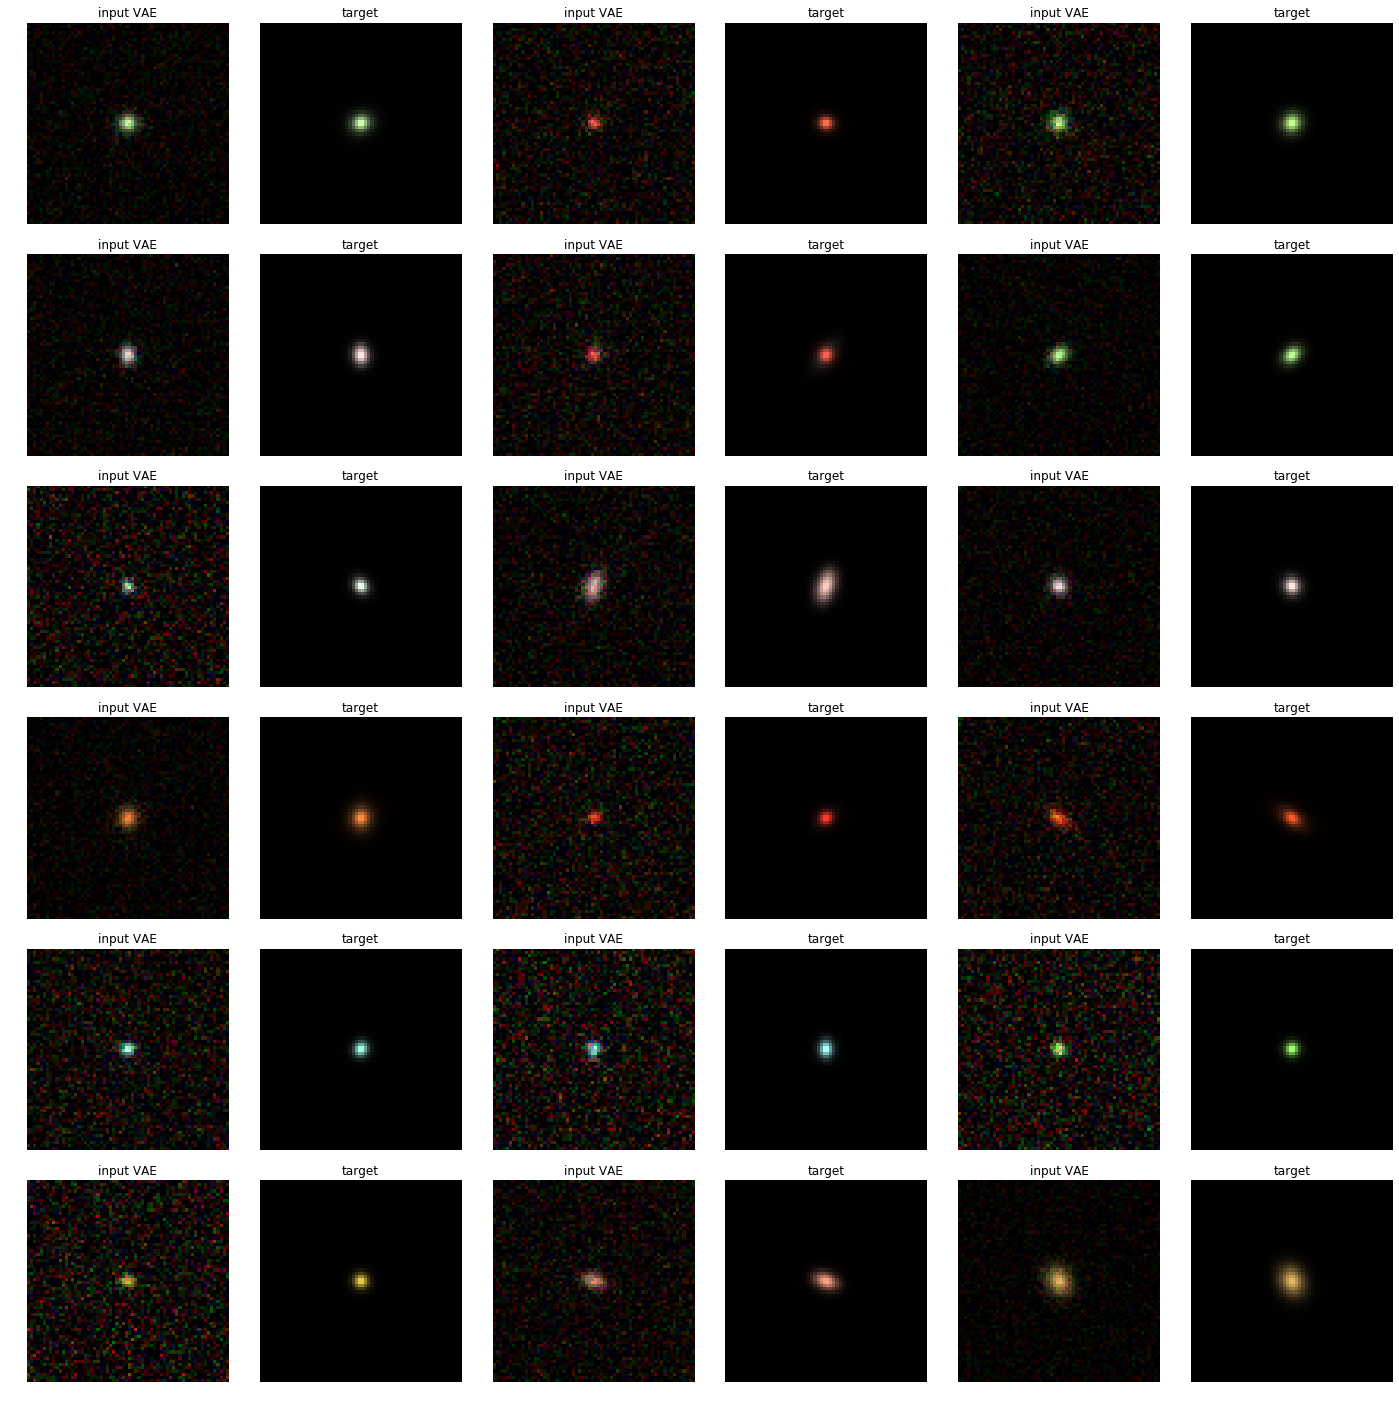

In [92]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        
        plot_rgb_lsst(np.transpose(galaxies[indices[i*N_plot+j]][1,4:], axes = (1,2,0)), stamp_size, axes[i,j])
        plot_rgb_lsst(np.transpose(galaxies[indices[i*N_plot+j]][0,4:], axes = (1,2,0)), stamp_size, axes[i,j+1])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target')

In [19]:
def compute_e (galaxies):
    PSF = galsim.Kolmogorov(fwhm=0.65)
    r_band = 2
    pix_scale = 0.2
    #final_epsf_image = PSF.drawImage(scale=0.2)

    psf_image = PSF.drawImage(nx=64, ny=64, scale=0.2)
    e = []
    error_list = []
    for i in range(len(galaxies)):
        try : 
            gal_image = galsim.Image(galaxies[i][:,:,r_band])
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_beta_in = [res.observed_shape.e]
            e.append(e_beta_in)
        except :
            print('erreur')
            error_list.append(i)
            pass
        continue
    return np.array(e),  error_list

In [27]:
e = []
for i in range (100):
    input_vae = batch_gen_lsst_test.__getitem__(2)

    input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
    e.append(compute_e(input_noiseless)[0])

In [28]:
e = np.concatenate(np.concatenate(e))

In [29]:
e.shape

(10000,)

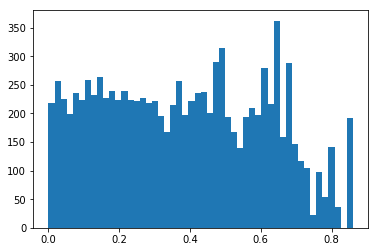

In [31]:
_ = plt.hist(e, bins = 50)

In [22]:
input_vae = batch_gen_lsst_test.__getitem__(2)

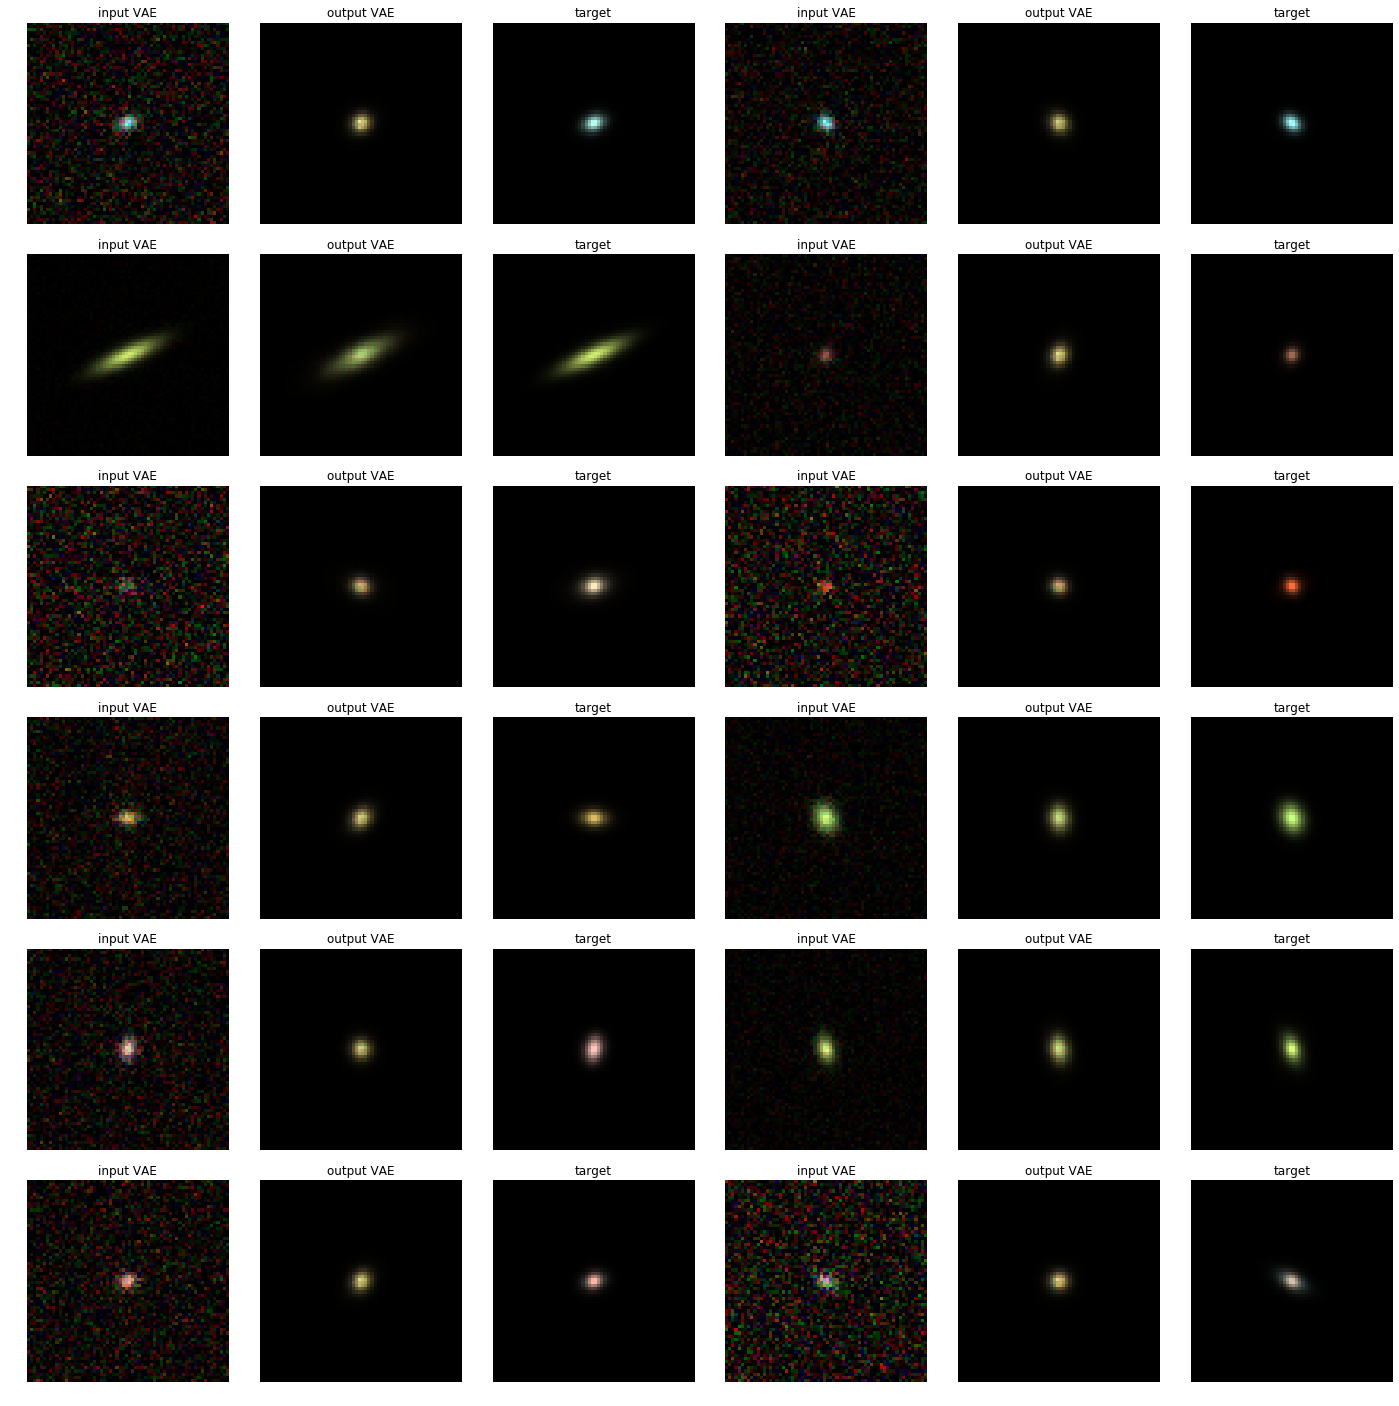

In [33]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_test.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

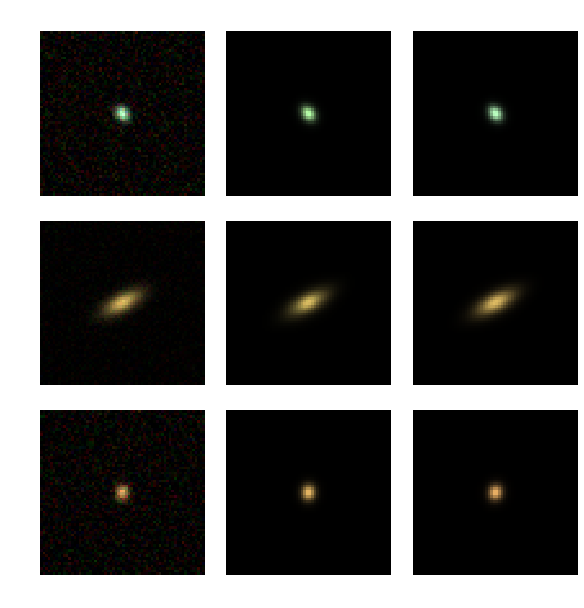

In [23]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

## LSST all filters

In [32]:
def VAE_processing_2(vae, generator, bands, r_band, im_size, N, batch_size, psf, pix_scale):
    """
    Returns 

    Paramters:
    ---------
    vae: vae to test
    generator: generator of input images (input of network and target) and parameters for processing results (SNR, scale radius)
    bands: band-pass filters used for this VAE
    r_band: R band-pass filter number in the bands list.
    im_size= size of the stamp for the creation of images
    N: number of batch to test
    batch_size: size of the batches generated by generator
    """

    # see LSST Science Book
    # pix_scale = 0.2 #arcseconds
    # PSF_fwhm = 0.1
    # PSF_beta = 2.5

    # psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
    psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

    ellipticities = []
    redshift_R=[]
    e=[]
    SNR = []
    scale_radius = []

    flux_in = np.empty([N,N,],dtype='float32')
    flux_out= np.empty([N,N,], dtype='float32')

    for j in range(N):
        input_vae = generator.__getitem__(2)
        output_vae = vae.predict(input_vae[0], batch_size = batch_size)
        #input_noiseless = input_vae[1]
        input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)
        output_vae = utils.denorm (output_vae, bands, channel_last = True)

        for i in range (len(input_vae[0])):
            try: 
                gal_image = galsim.Image(input_noiseless[i][:,:,r_band])
                gal_image.scale = pix_scale

                gal_image_out = galsim.Image(output_vae[i][:,:,r_band])
                gal_image_out.scale = pix_scale

                # Measurements of shapes
                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_in = [res.corrected_e1, res.corrected_e2]
                e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                res_out = galsim.hsm.EstimateShear(gal_image_out, psf_image)
                e_out = [res_out.corrected_e1, res_out.corrected_e2]
                e_beta_out = [res_out.observed_shape.e, res_out.observed_shape.beta.rad]

                ellipticities.append([e_in, e_out])
                e.append([e_beta_in, e_beta_out])

                # Measurement of fluxes
                mask = plot.createCircularMask(im_size,im_size,None,5)
                masked_img_in_simple = input_noiseless[i][:,:,r_band].copy()
                masked_img_in_simple[~mask] = 0  

                masked_img_out_simple = output_vae[i][:,:,r_band].copy()
                masked_img_out_simple[~mask] = 0

                # Calculate the luminosity by substracting the noise
                flux_in[j,i] = np.sum(masked_img_in_simple)
                flux_out[j,i] = np.sum(masked_img_out_simple)

            # Save scale radius and SNR
            #scale_radius.append(input_vae[2][i])
            #SNR.append(input_vae[3][i])
        
            except :
                print('erreur')
                pass
            continue

    ellipticities = np.array(ellipticities)
    e_beta = np.array(e)
    #scale_radius = np.array(scale_radius)
    #SNR = np.array(SNR)

    flux_in = np.concatenate(flux_in)
    flux_out = np.concatenate(flux_out)

    return ellipticities, e_beta, flux_in, flux_out#, scale_radius, SNR 

In [33]:
pix_scale = 0.2
fwhm_lsst = 0.65 # pdf.rvs() ## Fixed at median value : Fig 1 : https://arxiv.org/pdf/0805.2366.pdf
PSF_lsst = galsim.Kolmogorov(fwhm=fwhm_lsst)

In [43]:
N = 100
batch_size = 100

ellipticities_LSST, e_beta_LSST, lum_in_simple_lsst, lum_out_simple_lsst = VAE_processing_2(vae_lsst_conv, batch_gen_lsst,bands_lsst,2,stamp_size, N, batch_size, psf = PSF_lsst, pix_scale = pix_scale)#

erreur


In [23]:
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_vae_lsst.npy', [ellipticities_LSST,e_beta_LSST])
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_vae_flux_radius_SNR_lsst.npy', [lum_in_simple_lsst, lum_out_simple_lsst, scale_radius, SNR_lsst])

In [22]:
#ellipticities_LSST,e_beta_LSST = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_vae_lsst.npy')
#lum_in_simple_lsst, lum_out_simple_lsst, scale_radius, SNR_lsst = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_vae_flux_radius_SNR_lsst.npy')

In [47]:
delta_e_lsst = e_beta_LSST[:,1,0]- e_beta_LSST[:,0,0]
delta_e1_lsst = ellipticities_LSST[:,1,0]- ellipticities_LSST[:,0,0]
delta_e2_lsst = ellipticities_LSST[:,1,1]- ellipticities_LSST[:,0,1]


### Shape plots

Text(0, 0.5, 'e of output galaxy')

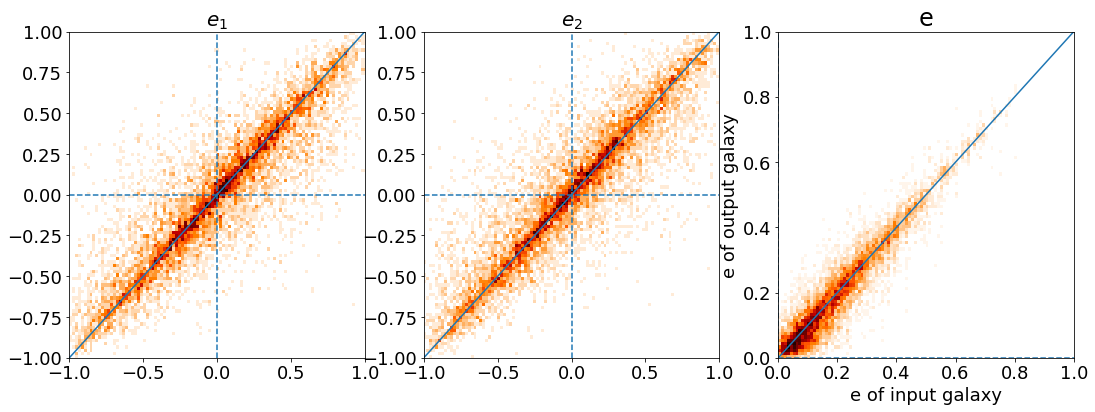

In [44]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST[:,0,i], ellipticities_LSST[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')
    
_ = axes[2].hist2d(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

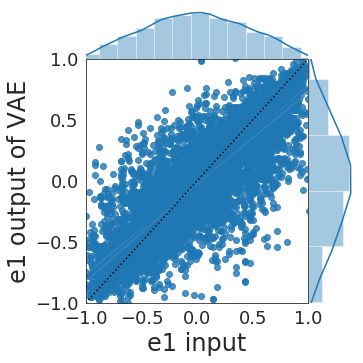

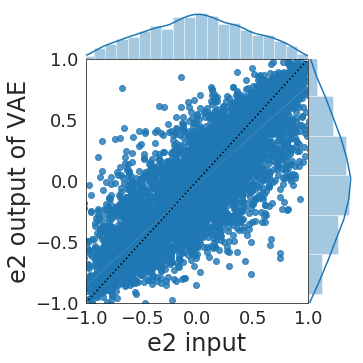

In [36]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST[:,0,0], ellipticities_LSST[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST[:,0,1], ellipticities_LSST[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

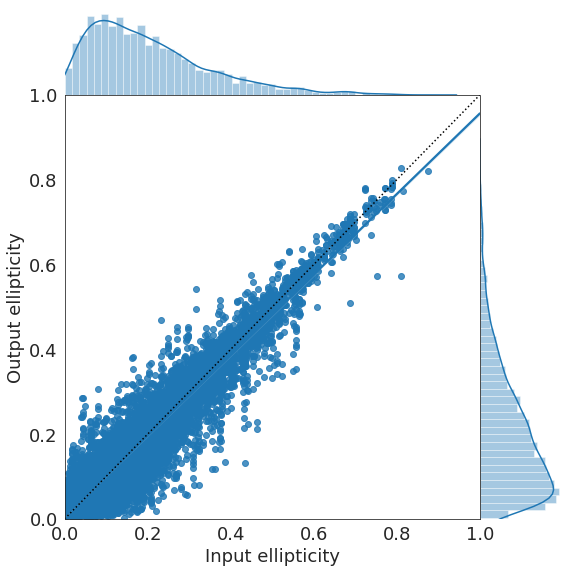

In [37]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}


with sns.axes_style('white'):
            g = sns.jointplot(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [45]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0])

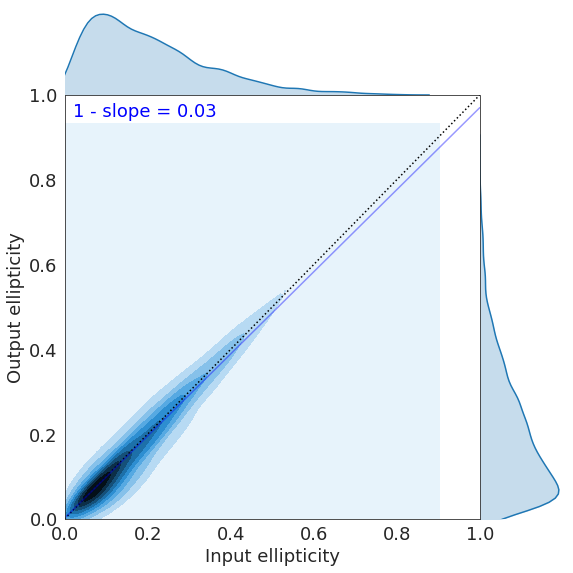

In [46]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst,color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

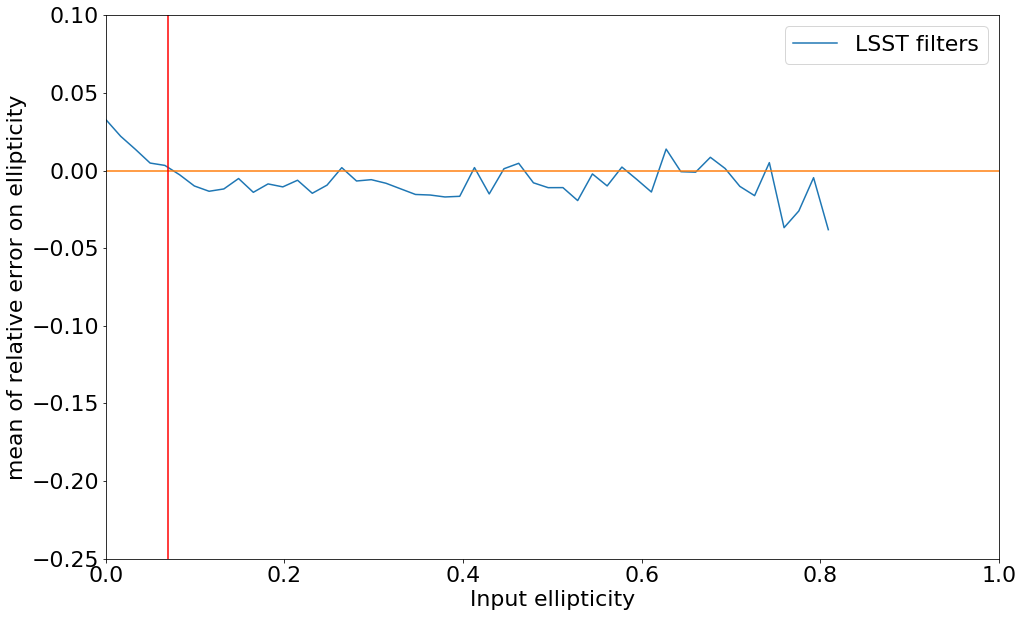

In [48]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


#mean_SNR_r, var_SNR_r = mean_var(e_beta_r[:,0,0],delta_e_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(e_beta_LSST[:,0,0],delta_e_lsst, bins = 50)
#mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(e_beta_LSST_euclid[:,0,0],delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(e_beta_LSST[:,0,0]), np.max(e_beta_LSST[:,0,0]), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


#plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
#plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.25, 0.1)
plt.plot(np.ones(50)*0.07, mid_snr, color = 'r')
plt.plot(np.ones(50)*0.07, -mid_snr, color = 'r')

plt.xlabel('Input ellipticity')
plt.ylabel('mean of relative error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)

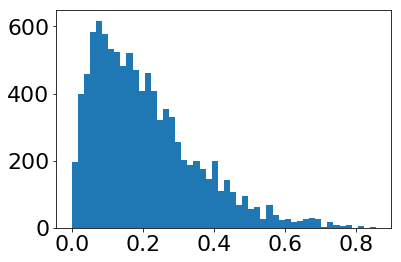

In [42]:
_ = plt.hist(e_beta_LSST[:,0,0], bins = 50)

### Luminosity plot

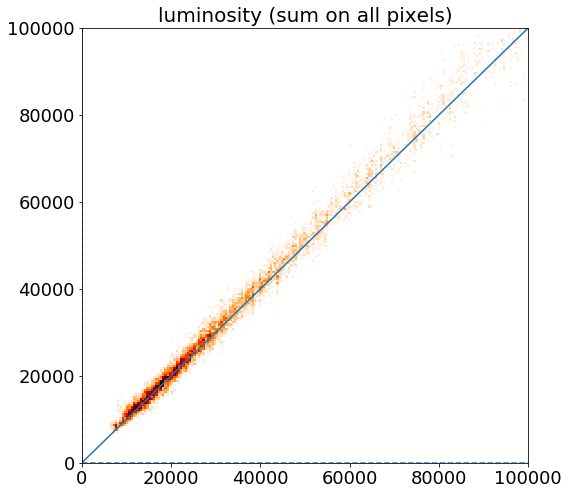

In [28]:
import matplotlib as mpl

fig, axes= plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_lsst, lum_out_simple_lsst, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

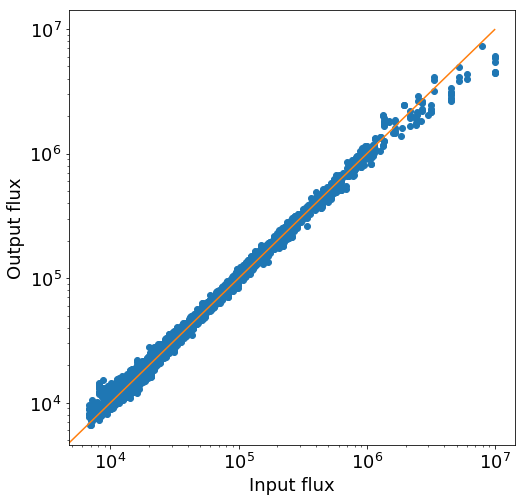

In [29]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(lum_in_simple_lsst)
axes.plot(lum_in_simple_lsst, lum_out_simple_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

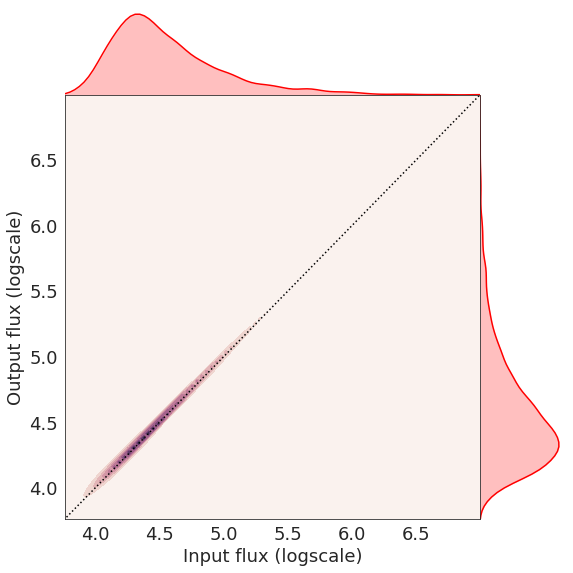

In [30]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(lum_in_simple_lsst), np.log10(lum_out_simple_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(lum_in_simple_lsst-1000)), np.max(np.log10(lum_in_simple_lsst))], ylim=[np.min(np.log10(lum_in_simple_lsst-1000)), np.max(np.log10(lum_in_simple_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(lum_in_simple_lsst))),
                            np.linspace(-1, np.max(np.log10(lum_in_simple_lsst))), ':k')